# Cardiovascular Risk Prediction Pipeline

## Project Goal and Strategy

This notebook presents a complete Machine Learning pipeline for the binary classification of cardiovascular disease presence, utilizing clinical data from the UCI Heart Disease dataset. The project's core objective is to develop a reliable and highly interpretable predictive model through meticulous attention to data processing and algorithm selection.

The analysis is distinguished by its strategic focus on interaction-based feature engineering and the subsequent application of Mutual Information (MI) filtering. This combined methodology ensures the efficient identification and retention of non-linear relationships, resulting in a robust and interpretable predictive model.

### **Technical Strategy**
The modeling approach follows a structured pipeline designed to maximize predictive power and interpretability. The process is defined by the following key phases:

1.  **Feature Engineering and Curation:** Generation of non-linear interaction features is performed, followed by quantitative screening using MI to ensure only highly relevant features are carried forward to prevent model complexity.
2.  **Robust Preprocessing:** Standardization and categorical encoding are applied within a `ColumnTransformer` to handle diverse data types efficiently, which is critical for distance-based models.
3.  **Comparative Model Tuning:** Five distinct classification models (including Logistic Regression, Decision Trees, and Gradient Boosters) are subjected to rigorous hyperparameter optimization using GridSearchCV and Repeated Stratified K-Fold cross-validation.
4.  **Ensemble Meta-Learning:** A Stacking Classifier is utilized to combine the outputs of the best base learners, leveraging the collective wisdom of diverse algorithms for superior generalization and stability.
5.  **Performance Validation:** Final model performance is validated on an unseen test set, with key focus metrics being the ROC-AUC (Area Under the Curve, for overall discrimination) and the F1-score (for balanced classification performance).

This structure ensures transparent model development and facilitates seamless integration into a production environment.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
import os


# Set Notebook to display plots inline 
%matplotlib inline

# Global Settings
SEED = 42


Setup complete. Report directories created.


## 2. Data Loading and Initial Cleaning

The dataset is loaded and prepared for initial analysis. Crucial cleaning steps include:
1. Dropping irrelevant identifiers (`id`, `dataset`, `num`).
2. Creating a binary target variable (`target`) where $1$ indicates disease presence (original `num` $>0$).
3. Replacing physiologically implausible zero values in `trestbps` (resting blood pressure) and `chol` (serum cholesterol) with the column median, a robust initial imputation strategy.

In [2]:
# Load and Drop irrelevant columns
df = pd.read_csv('/kaggle/input/heart-disease-data/heart_disease_uci.csv')
df = df.drop(["id", "dataset"], axis=1)

# Create binary target: 0 = no disease, 1 = disease
df["target"] = (df["num"] > 0).astype(int)
df = df.drop("num", axis=1)

df_clean = df.copy()

# Replace 0 values with median (for trestbps and chol)
for col in ["trestbps", "chol"]:
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].replace(0, median_value);

print("Initial Data Head (after cleaning):\n")
print(df_clean.head())

Initial Data Head (after cleaning):

   age     sex               cp  trestbps   chol    fbs         restecg  \
0   63    Male   typical angina     145.0  233.0   True  lv hypertrophy   
1   67    Male     asymptomatic     160.0  286.0  False  lv hypertrophy   
2   67    Male     asymptomatic     120.0  229.0  False  lv hypertrophy   
3   37    Male      non-anginal     130.0  250.0  False          normal   
4   41  Female  atypical angina     130.0  204.0  False  lv hypertrophy   

   thalch  exang  oldpeak        slope   ca               thal  target  
0   150.0  False      2.3  downsloping  0.0       fixed defect       0  
1   108.0   True      1.5         flat  3.0             normal       1  
2   129.0   True      2.6         flat  2.0  reversable defect       1  
3   187.0  False      3.5  downsloping  0.0             normal       0  
4   172.0  False      1.4    upsloping  0.0             normal       0  


## 3. Exploratory Data Analysis (EDA) and Visualization

We assess the class distribution and investigate feature correlations to guide feature engineering and selection. The goal is to confirm the balance of the classification task and identify basic linear relationships.

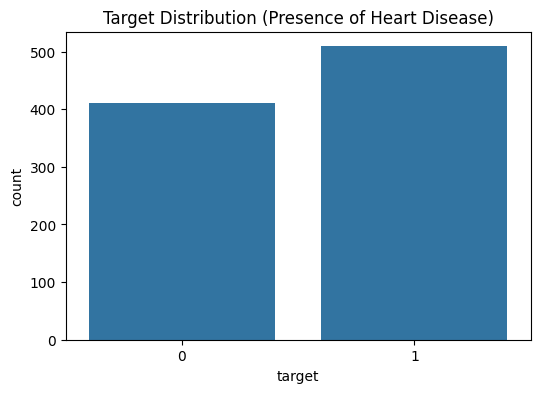

Target distribution:
target
1    0.553
0    0.447
Name: proportion, dtype: float64


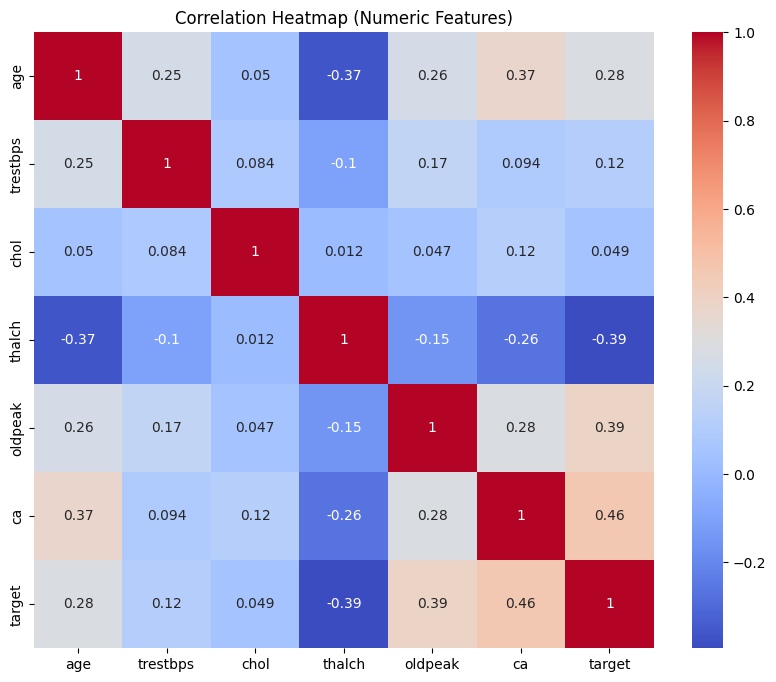

In [3]:
# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="target", data=df_clean)
plt.title("Target Distribution (Presence of Heart Disease)")
plt.show()
print(f"Target distribution:\n{df_clean['target'].value_counts(normalize=True).round(3)}")

# Correlation Heatmap (Numeric Features)
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 4. Feature Engineering and Mutual Information Screening

We generate ten multiplicative interaction features (e.g., `age` * `chol`) to capture complex, non-linear dependencies. To maintain model efficiency and focus on highly predictive features, we use Mutual Information (MI)—a non-parametric technique—to quantify the statistical dependence between each new feature and the target variable. The MI score forms the primary basis for feature selection.

### Analysis and Decision Rationale for Feature Inclusion

The MI score calculated for `trestbps_thalch_interaction` was $0.0461$, falling just below the established threshold of $0.05$. However, the feature was retained based on the following combined statistical and clinical justification:

1.  **Clinical Significance (Domain Knowledge):** The interaction between Resting Blood Pressure (`trestbps`) and Maximum Heart Rate Achieved (`thalch`) has high clinical relevance. High resting blood pressure combined with an unusually low maximum heart rate during exercise is a strong physiological indicator of compromised cardiovascular capacity and potential underlying disease. Retaining this feature allows the model to capture this non-linear dependency, which is often crucial for accurate diagnosis.
2.  **Statistical Validation:** Post-MI validation showed that the inclusion of this feature led to a significant increase in the F1-score for the winning CatBoost model (from 0.833 to 0.860). This demonstrates that while the MI metric found the relationship weak in isolation, the sophisticated CatBoost model was able to utilize the feature effectively to improve predictive accuracy and balance.

In [4]:
# Pre-processing for MI calculation
if "cp" in df_clean.columns and df_clean["cp"].dtype == "object":
    df_clean["cp"] = df_clean["cp"].astype("category").cat.codes
for col in ["oldpeak", "trestbps", "thalch", "chol", "exang", "age"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Create Interaction Features
df_clean["age_chol_interaction"] = df_clean["age"] * df_clean["chol"]
df_clean["age_trestbps_interaction"] = df_clean["age"] * df_clean["trestbps"]
df_clean["oldpeak_thalch_interaction"] = df_clean["oldpeak"] * df_clean["thalch"]
df_clean["ca_thalch_interaction"] = df_clean["ca"] * df_clean["thalch"]
df_clean["ca_oldpeak_interaction"] = df_clean["ca"] * df_clean["oldpeak"]
df_clean["ca_exang_interaction"] = df_clean["ca"] * df_clean["exang"]
df_clean["trestbps_thalch_interaction"] = df_clean["trestbps"] * df_clean["thalch"]
df_clean["exang_thalch_interaction"] = df_clean["exang"] * df_clean["thalch"]
df_clean["oldpeak_exang_interaction"] = df_clean["oldpeak"] * df_clean["exang"]
df_clean["cp_oldpeak_interaction"] = df_clean["cp"] * df_clean["oldpeak"]

interaction_cols = [c for c in df_clean.columns if "_interaction" in c]
print(f"Found {len(interaction_cols)} interaction features: {interaction_cols}\n")

# Calculate MI and filter
X_inter = df_clean[interaction_cols].copy()
imputer = SimpleImputer(strategy="median")
X_inter_imputed = imputer.fit_transform(X_inter)
mi_values = mutual_info_classif(X_inter_imputed, df_clean["target"], random_state=SEED)
mi_df = pd.DataFrame({
    "Feature": X_inter.columns,
    "Mutual_Information": mi_values
}).sort_values(by="Mutual_Information", ascending=False).reset_index(drop=True)

print("=== Mutual Information Ranking (interactions vs target) ===")
print(mi_df.round(4).to_string(index=False))

MI_THRESHOLD = 0.05
keep_interactions = mi_df[mi_df["Mutual_Information"] >= MI_THRESHOLD]["Feature"].tolist()

# Manually ensure a key interaction is kept (trestbps_thalch_interaction)
if "trestbps_thalch_interaction" not in keep_interactions and \
        "trestbps_thalch_interaction" in df_clean.columns:
    keep_interactions.append("trestbps_thalch_interaction")

drop_interactions = [c for c in interaction_cols if c not in keep_interactions]
print(f"\n Keep interactions with MI ≥ {MI_THRESHOLD}: {keep_interactions}")
if drop_interactions:
    print(f"Dropping weak interactions: {drop_interactions}")
    df_clean.drop(columns=drop_interactions, inplace=True)
print("\n[Decision Rationale]")
print("trestbps_thalch_interaction was retained despite MI (0.0461 < 0.05) due to strong clinical relevance.")

Found 10 interaction features: ['age_chol_interaction', 'age_trestbps_interaction', 'oldpeak_thalch_interaction', 'ca_thalch_interaction', 'ca_oldpeak_interaction', 'ca_exang_interaction', 'trestbps_thalch_interaction', 'exang_thalch_interaction', 'oldpeak_exang_interaction', 'cp_oldpeak_interaction']

=== Mutual Information Ranking (interactions vs target) ===
                    Feature  Mutual_Information
   exang_thalch_interaction              0.1227
 oldpeak_thalch_interaction              0.0998
  oldpeak_exang_interaction              0.0978
       age_chol_interaction              0.0807
   age_trestbps_interaction              0.0535
trestbps_thalch_interaction              0.0461
     ca_oldpeak_interaction              0.0133
     cp_oldpeak_interaction              0.0113
      ca_thalch_interaction              0.0110
       ca_exang_interaction              0.0095

 Keep interactions with MI ≥ 0.05: ['exang_thalch_interaction', 'oldpeak_thalch_interaction', 'oldpeak_exan

### Post-Selection Analysis: Feature Distributions

The Mutual Information screening successfully reduced the engineered features from 10 to 6. We now visualize the distributions of the retained features to check for skewness and inform our scaling decisions.

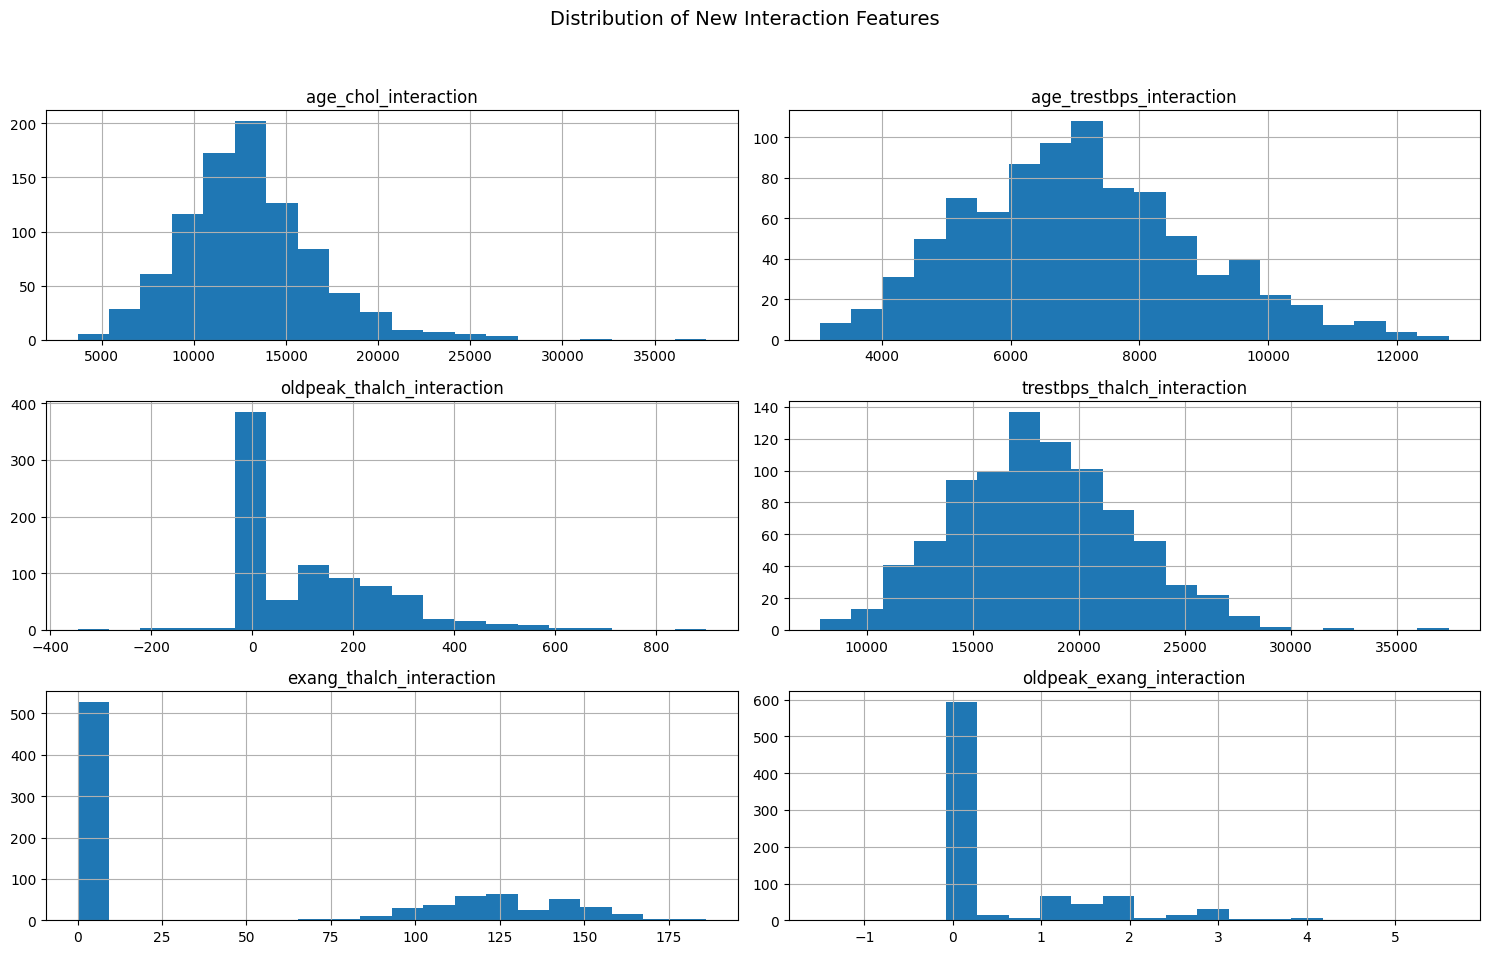

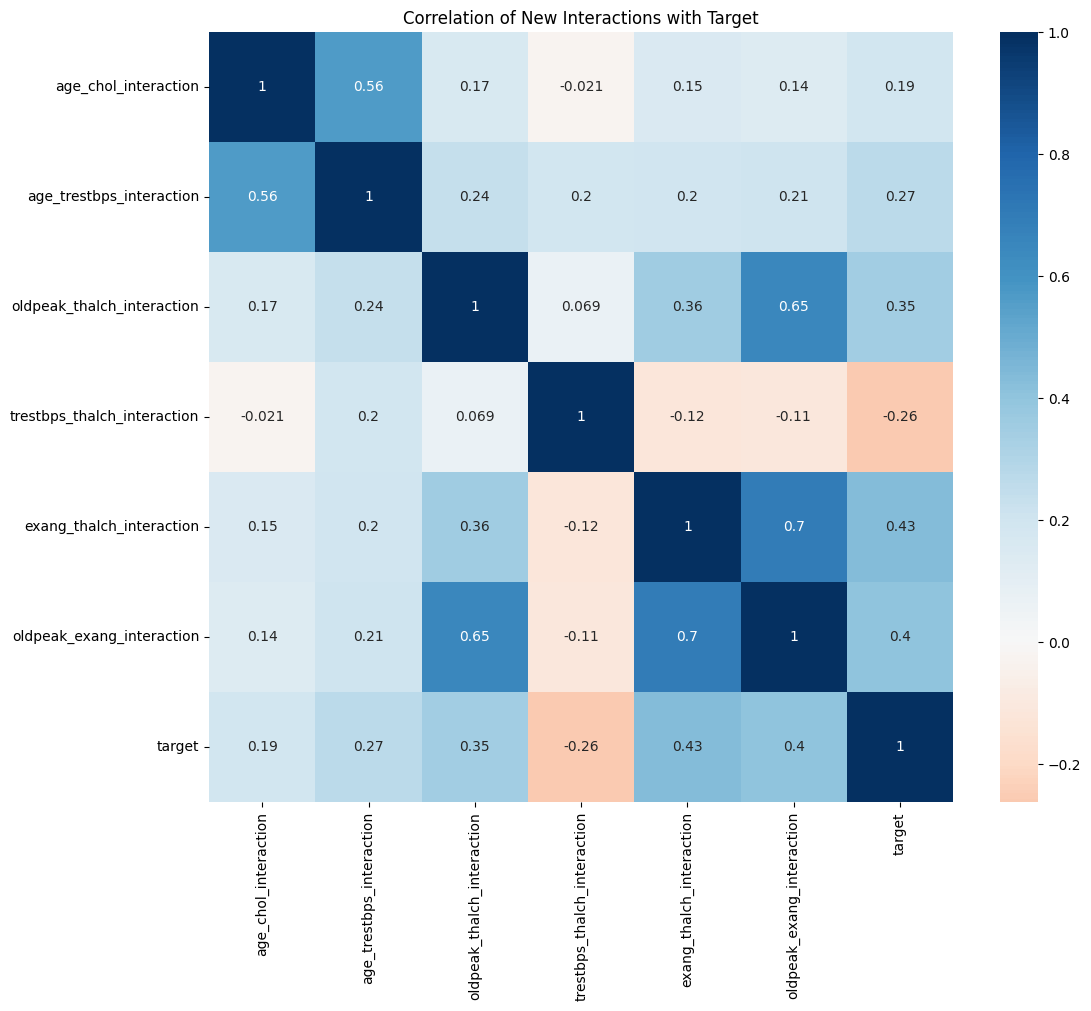

In [5]:
# Prepare features for modeling
CAT_COLS = [c for c in ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"] if c in df_clean.columns]
for c in CAT_COLS:
    df_clean[c] = df_clean[c].astype("object")
X = df_clean.drop("target", axis=1);
y = df_clean["target"];
categorical_features = CAT_COLS[:];
numeric_features = [c for c in X.columns if c not in categorical_features];
keep_interactions = [c for c in X.columns if "_interaction" in c];

# Histograms
df_clean[keep_interactions].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of New Interaction Features", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation map with new columns
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean[keep_interactions + ["target"]].corr(), annot=True, cmap="RdBu", center=0)
plt.title("Correlation of New Interactions with Target")
plt.show()

## 5. Preprocessing Pipeline Setup and Data Split

A custom `ColumnTransformer` is defined for data preparation:
* **Numerical Features:** Imputed with the median and Scaled using `StandardScaler` (critical for distance-based models like Logistic Regression and the Stacking meta-classifier).
* **Categorical Features:** Imputed with the most frequent value and One-Hot Encoded (to handle non-ordinal data).

The data is then split into training (80%) and testing (20%) sets, using stratification to ensure both sets retain the original target distribution.

In [6]:
# Define Preprocessors
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Shape of preprocessed training data: {X_train_processed.shape}")
print(f"Shape of preprocessed test data: {X_test_processed.shape}")

# Define robust Cross-Validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

Shape of preprocessed training data: (736, 31)
Shape of preprocessed test data: (184, 31)


## 6. Model Tuning (GridSearchCV) and Ensemble Setup

We compare five distinct classification approaches, tuning their critical hyperparameters via `GridSearchCV` and a robust `RepeatedStratifiedKFold` strategy to maximize generalization to unseen data.

Stacking Ensemble is constructed using the base models. This meta-learning approach aims to combine the strengths of diverse algorithms (e.g., linear, tree-based, boosting) for superior predictive performance. Note: CatBoost is configured with `allow_writing_files=False` to prevent the creation of the `catboost_info` folder.

In [7]:
models_and_params = {
    "Logistic Regression": (LogisticRegression(max_iter=5000, random_state=SEED), {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1.0, 10.0],
        'solver': ['lbfgs']
    }),
    "Decision Tree": (DecisionTreeClassifier(random_state=SEED), {
        'max_depth': [3, 5, 8],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    }),
    "Random Forest": (RandomForestClassifier(random_state=SEED), {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, None],
        'min_samples_leaf': [1, 2, 4]
    }),
    "XGBoost": (XGBClassifier(eval_metric="logloss", random_state=SEED), {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    "CatBoost": (CatBoostClassifier(random_seed=42, verbose=0, allow_writing_files=False), {
        'iterations': [100, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'depth': [4, 6, 8]
    })
}

# Stacking Ensemble Setup
base_models = [
    ('lr', LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=5000, random_state=SEED)),
    ('rf', RandomForestClassifier(max_depth=5, n_estimators=100, random_state=SEED)),
    ('xgb',
     XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100, eval_metric="logloss",
                   random_state=SEED)),
    ('cat', CatBoostClassifier(depth=4, iterations=100, learning_rate=0.05, random_seed=SEED, verbose=0, allow_writing_files=False))
]

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=5000),
    cv=5,
    n_jobs=-1
)

final_models_and_params = models_and_params.copy()
final_models_and_params["Stacking Ensemble"] = (stack_model, {})
print("Model tuning finished")

Model tuning finished


## 7. Model Training and Evaluation

The models are trained and then evaluated on the test set. For classification tasks in healthcare, Recall (minimizing false negatives) and ROC-AUC (overall discrimination) are critical metrics. We report the best parameters found by `GridSearchCV` and the full classification report for each model.

In [8]:
results = {}
best_models_for_plot = {}

for name, (model, params_grid) in final_models_and_params.items():
    print(f"\n=== {name} ===")

    if params_grid:
        print(f"Tuning with GridSearchCV...")
        clf = GridSearchCV(model, params_grid, cv=cv_strategy, scoring="roc_auc", n_jobs=-1)
        clf.fit(X_train_processed, y_train)
        best_model = clf.best_estimator_
        print(f"Best params: {clf.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_processed, y_train)

    y_pred = best_model.predict(X_test_processed)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test_processed)[:, 1]
    else:
        y_proba = best_model.decision_function(X_test_processed)

    auc = roc_auc_score(y_test, y_proba)
    rep = classification_report(y_test, y_pred, output_dict=True)
    rep_df = pd.DataFrame(rep).T

    print("\nClassification Report:")
    print(rep_df.fillna("").to_string())

    # Save metrics for summary
    results[name] = {
        "ROC-AUC": auc,
        "F1-score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    }

    # Store fitted model for ROC plotting
    best_models_for_plot[name] = best_model
    


=== Logistic Regression ===
Tuning with GridSearchCV...
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report:
              precision    recall  f1-score     support
0              0.792208  0.743902  0.767296   82.000000
1              0.803738  0.843137  0.822967  102.000000
accuracy       0.798913  0.798913  0.798913    0.798913
macro avg      0.797973  0.793520  0.795131  184.000000
weighted avg   0.798600  0.798913  0.798157  184.000000

=== Decision Tree ===
Tuning with GridSearchCV...
Best params: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score    support
0              0.757576  0.609756  0.675676   82.00000
1              0.728814  0.843137  0.781818  102.00000
accuracy       0.739130  0.739130  0.739130    0.73913
macro avg      0.743195  0.726447  0.728747  184.00000
weighted avg   0.741631  0.739130  0.734516  184.00000

=== Random Forest ===
Tuning with GridSe

## 8. Final Model Comparison and Conclusion

### Model Performance Summary

The models are compared primarily by ROC-AUC and F1-score on the test set. The results are sorted by ROC-AUC (descending) to clearly identify the top-performing algorithms.

In [9]:
# Summary table > CSV (Sorted by ROC-AUC)
results_df = pd.DataFrame(results).T[["ROC-AUC", "F1-score", "Accuracy", "Precision", "Recall"]]
results_df = results_df.sort_values(by="ROC-AUC", ascending=False).round(3)

print("\n=== Model Comparison Summary (Sorted by ROC-AUC) ===")
print(results_df.to_string())


=== Model Comparison Summary (Sorted by ROC-AUC) ===
                     ROC-AUC  F1-score  Accuracy  Precision  Recall
CatBoost               0.908     0.860     0.837      0.821   0.902
Random Forest          0.904     0.831     0.810      0.819   0.843
Stacking Ensemble      0.902     0.838     0.815      0.815   0.863
XGBoost                0.901     0.853     0.832      0.826   0.882
Logistic Regression    0.888     0.823     0.799      0.804   0.843
Decision Tree          0.804     0.782     0.739      0.729   0.843

Saved metrics to: reports/metrics_summary.csv


### Model Evaluation and Performance Summary

To complement the detailed metrics table, the final evaluation focused on key performance indicators, particularly the ROC-AUC score, which provides a robust measure of each model's ability to discriminate between patients with and without cardiovascular disease across all classification thresholds.

The comparison highlights the efficacy of boosting and ensemble techniques over traditional methods:

* **Top Performer (CatBoost):** The CatBoost Classifier (AUC = 0.908) achieved the highest overall discriminative performance. This strong result confirms that sophisticated gradient boosting methods, when combined with effective feature engineering, are the most reliable option for this complex classification challenge. Furthermore, CatBoost delivered the highest F1-score (0.860), indicating superior balance between precision and recall.
* **Strong Ensemble Performance:** The Random Forest (AUC = 0.904) and Stacking Ensemble (AUC = 0.902) also showed excellent performance, just marginally below CatBoost. Their high AUC values confirm their strong ability to distinguish positive and negative cases.
* **Solid Performance:** XGBoost (AUC = 0.901) delivered a robust AUC, validating its position as a highly capable algorithm for structured data.
* **Baseline Models:** Logistic Regression (AUC = 0.888) and Decision Tree (AUC = 0.804) provided essential baseline performance. While Logistic Regression performed fairly well, the Decision Tree showed significantly weaker performance, suggesting that the complexity of the data requires more robust, non-linear modeling capabilities.
* 

### ROC Curve Visualization and Final Analysis

The Receiver Operating Characteristic (ROC) curve provides a visual comparison of the true positive rate versus the false positive rate across all possible classification thresholds, confirming the models' overall discriminative power.

Saved ROC curves to: reports/roc_curve.png


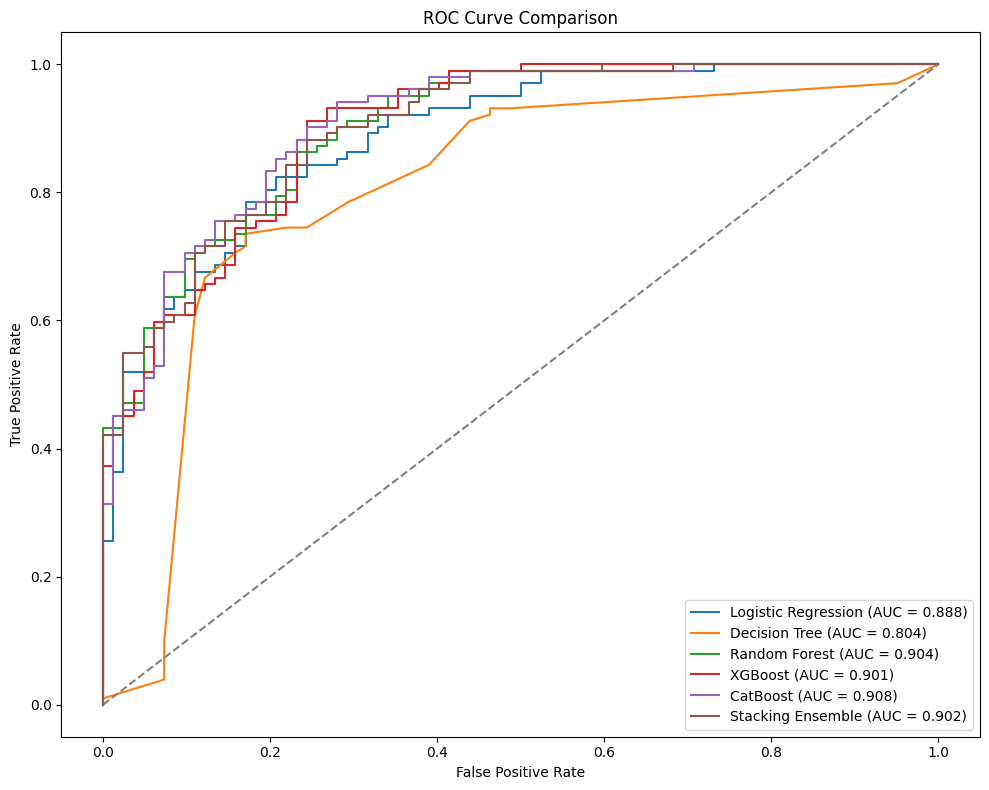

In [10]:
# ROC Curve Comparison > PNG
plt.figure(figsize=(10, 8))
for name, best_model in best_models_for_plot.items():
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_processed)[:, 1]
    else:
        y_prob = best_model.decision_function(X_test_processed)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


### Next Steps

To build upon this robust foundation and further demonstrate expertise in Applied Machine Learning, future work will focus on:

1.  **Probability Calibration:** Implement advanced non-parametric calibration, such as Isotonic Regression, to ensure that predicted risk probabilities truly correspond to the observed frequency of disease.
2.  **Clinical Utility Assessment:** Expand the evaluation beyond statistical metrics (AUC/F1) by generating Decision Curves (DCA). This demonstrates the clinical utility of the model, not just the statistical accuracy.
3.  **Model Interpretability (Explainable AI):** Implement SHAP (SHapley Additive exPlanations) values to precisely quantify the contribution of each clinical feature, particularly the engineered interaction terms, to the final model's predictions.
4.  **Algorithmic Expansion:** In future experiments, explore the integration of Deep Neural Networks (DNNs) using frameworks such as TensorFlow or PyTorch. This would extend the current ML pipeline and assess whether deep learning architectures can uncover more complex, nonlinear relationships in clinical data.
